# Phase-Amplitude couplings

How to compute phase-amplitude relationship, such as coherence based measure and phase-locking to amplitude modulation in continuous settings.

One easy way to measure such couplings is simply by looking at the phase of a slow oscillator $\phi_{slow}$ in relation with the amplitude of a faster one $\rho_{fast}$ such as, e.g. slow and fast being $\delta$ and $\beta$, computed as the mean vector length of the compound analytical signal:

$$
C(\delta, \beta) = | \frac{1}{N}\sum_{i=1}^N{\phi_{\delta}(t) \times \rho_{\beta}(t)} |\\
                 = | \frac{1}{N}\sum_{i=1}^N{\rho_{\beta}(t)e^{i\theta(t)}} |\\
$$


In [this paper](https://www.frontiersin.org/articles/10.3389/fnins.2017.00487/full), there is a comparison for those measures:
- Mean-Vector Length modulation index, originally described in Canolty et al. (2006):
$$
C(\delta, \beta) = | \frac{1}{N}\sum_{i=1}^N{\rho_{\beta}(t)e^{i\theta(t)}} |
$$
- Mean-Vector Length modulation index described in Özkurt and Schnitzler (2011):
$$
C(\delta, \beta) = | \frac{1}{\sqrt{N}}\frac{\sum_{i=1}^N{\rho_{\beta}(t)e^{i\theta(t)}}}{\sqrt{\sum{\rho(t)^2}}} |
$$
- phase-locking value modulation index described in Cohen (2008):
$$
C(\delta, \beta) = | \frac{1}{N}\sum_{i=1}^N{e^{i(\theta(t) - \phi{\rho(t)})}} |
$$
- the Kullback-Lieber modulation index described in [Tort et al. (2010b)](https://journals.physiology.org/doi/full/10.1152/jn.00106.2010)
$$
C(\delta, \beta) = | \frac{KL(D||Q)}{\log(N_{bins})} |
$$


Finally, the KL-MI-Tort approach estimates PAC by quantifying the amount of deviation in amplitude-phase distributions. This involves breaking fp into 18 bins, and calculating the mean amplitude within each phase bin, normalized by the average value across all bins. Although the number of phase bins chosen is arbitrary, the specific number (9, 18, or 36) does not seem to influence PAC estimation (Figure S1; van Driel et al., 2015). The modulation index is calculated by comparing the amplitude-phase distribution (P) against the null hypothesis of a uniformly amplitude-phase distribution (Q).

---

### References

Github for comparison : [here](https://github.com/neurofractal/PACmeg).

- Original PAC formula: Canolty et al. (2006)
- Updated formula (normalising power): Özkurt and Schnitzler (2011)
- Mike Cohen's formula: Cohen (2008)
- KL-based coupling: [Tort et al. (2010b)](https://journals.physiology.org/doi/full/10.1152/jn.00106.2010)
- Summary from: "_The detection of phase amplitude coupling during sensory processing_", 2017, Frontiers in Neuroscience

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from scipy.signal import hilbert
from tqdm.notebook import tqdm
from collections import namedtuple

MI = namedtuple('modulation_index', ['mean_vector', 'normalised_mean_vector', 'plv', 'kl'])

def normalize_complex(z):
    return z/abs(z)

#### PAC library of functions to measure modulation and generate signal
##### Metrics

In [ ]:
def check_complex(amp, phase):
    if any(np.iscomplex(amp)):                                                                                                                              
        amp = abs(amp)                                                                                                                                      
    if any(np.iscomplex(phase)):                                                                                                                            
        phase = np.angle(phase)  
    return amp, phase

def compute_amp_phase_distribution(amp, phase, n_bins=18):
     # If complex input, take amplitude and phase angle manually first                                                                                       
    amp, phase = check_complex(amp, phase)                                                                                                                            
                                                                                                                                                            
    # Phase must be between 0 and 2 pi                                                                                                                      
    phase = phase%(2*np.pi) #+ np.pi * (1-np.sign(phase))
    bin_edges = np.linspace(0, 2*np.pi, n_bins+1)                                                                                                           
    amp_pmf = np.zeros((n_bins,))                                                                                                                           
    binned_count = np.zeros((n_bins,)) # to take the mean of amplitude values per bin                                                                       
    for r, phi in zip(amp, phase):                                                                                                                          
        bin_idx = np.argmin(abs(bin_edges - phi))%n_bins                                                                                                    
        amp_pmf[bin_idx] += r                                                                                                                               
        binned_count[bin_idx] += 1                                                                                                                          
    # Take average amplitude per bin                                                                                                                        
    amp_pmf[binned_count!=0] /= binned_count[binned_count!=0]                                                                                               
                                                                                                                                                            
    # Normalize to get a probability distribution                                                                                                           
    amp_pmf /= amp_pmf.sum()
    
    # Bin centers:
    bins = bin_edges[:-1] + np.diff(bin_edges)/2
    
    return amp_pmf, bins

def modulation_index_tort2010(amp, phase, n_bins=18):
    """
    Modulation index as computed with the KL divergence, see Tort et al. (2010).
    """                                                                                                                                                                                                                                               
    amp_pmf, bins = compute_amp_phase_distribution(amp, phase, n_bins)                                                                                                                                
                                                                                                                                                            
    entropy = -np.sum(amp_pmf[amp_pmf!=0] * np.log(amp_pmf[amp_pmf!=0]))                                                                                    
                                                                                                                                                            
    return 1-entropy/np.log(n_bins) # = DL(P(r) ; Uniform)/log(n)

def modulation_index_canolty2006(amp, phase):
    # If complex input, take amplitude and phase angle manually first                                                                                       
    amp, phase = check_complex(amp, phase)
    return np.abs(np.mean(amp * np.exp(1j*phase)))

def modulation_index_ozkurt2011(amp, phase):
    # If complex input, take amplitude and phase angle manually first                                                                                       
    amp, phase = check_complex(amp, phase)
    return np.abs(np.sum(amp * np.exp(1j*phase))/np.sqrt(np.sum(np.square(amp)))/np.sqrt(len(phase)))

def modulation_index_cohen2008_PLV(amp, phase):
    # If complex input, take amplitude and phase angle manually first                                                                                       
    amp, phase = check_complex(amp, phase)
    amp_phase = np.angle(hilbert(amp))
    return np.abs(np.mean(np.exp(1j*(phase - amp_phase))))

def compute_all_MI(amp, phase):
    return MI(modulation_index_canolty2006(amp, phase),
              modulation_index_ozkurt2011(amp, phase),
              modulation_index_cohen2008_PLV(amp, phase),
              modulation_index_tort2010(amp, phase))

##### Simulations

In [ ]:
fs = 200
dur = 60 # 2 min duration
f_slow = 3.5 # Hz
f_fast = 20. # Hz
t = np.arange(0, dur, 1/fs)
lags = np.arange(-0.2, 0.6, 1/fs)

def generate_modulated_signal(t, mod_factor, f_slow=4, f_fast=35, noise=0.2):
    # main signals of interest slow, envelope and carrier
    signal_slow = np.sin(2*np.pi*f_slow*t)
    carrier_fast = np.sin(2*np.pi*f_fast*t)
    env_fast = abs(1 + mod_factor * signal_slow + np.random.randn(*signal_slow.shape) * noise)
    # "Always on" modulation
    signal_fast = env_fast * carrier_fast
    return signal_slow, signal_fast, env_fast, carrier_fast

def generate_event_modulated_signal(t, env_fast, carrier_fast, Neve=200, f_slow=4, f_fast=35):
    # events structure
    idx = np.random.choice(np.arange(len(t)), size=(Neve,), replace=False)
    onsets = np.zeros_like(t)
    valued = np.zeros_like(onsets)
    onsets[idx] = 1
    valued[idx] = abs(np.random.randn(Neve,))

    # Modulation kernel
    lags = np.arange(-0.2, 0.6 + 1/fs, 1/fs)
    kernel = norm.pdf(lags, loc=0.1, scale=0.05)
    kernel /= np.std(kernel)

    # Simulate modulation time-series
    lag_samples = np.round(fs*lags).astype(int)
    modulator_onset = np.convolve(onsets.flatten(), np.pad(kernel, (max(lag_samples)+min(lag_samples), 0)), mode='same')
    modulator_value = np.convolve(valued.flatten(), np.pad(kernel, (max(lag_samples)+min(lag_samples), 0)), mode='same')

    # modulation is stronger at certain events
    signal_fast_onset = env_fast * modulator_onset * carrier_fast

    # modulation depends on external value
    signal_fast_val = env_fast * carrier_fast * modulator_value
    
    return signal_fast_onset, signal_fast_val, onsets, valued, modulator_onset, modulator_value

##### Plotting

In [ ]:
def plot_phase_amp_distribution(bins, pmf, ax=None):
    if ax is None:
        f, ax = plt.subplots(1, 1)
    b = ax.bar(bins, pmf, alpha=0.8, width=bins[1]-bins[0])
    ax.margins(x=0)
    ax.set_xticks(np.linspace(0, 2*np.pi, 5))
    ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$3\frac{\pi}{2}$', r'$2\pi$'])
    ax.grid(axis='x', which='both')
    sns.despine(ax=ax)
    return b

def plot_sig(t, signal_fast, env_fast, ax=None):
    if ax is None:
        f, ax = plt.subplots(1, 1)
    l = ax.plot(t, np.asarray([signal_fast, env_fast]).T)
    ax.margins(x=0)
    ax.set_xlim([0, 1.5])
    sns.despine(ax=ax)
    return l

def plot_complex_circle(signal_slow, signal_fast, ax=None, **kwargs):
    if ax is None:
        f, ax = plt.subplots(1, 1, subplot_kw={'projection':'polar'})
    amp, phase = check_complex(abs(hilbert(signal_fast)), normalize_complex(hilbert(signal_slow)))
    ax.plot(phase, amp, **kwargs) # amp*np.exp(1j*phase)
    # Add mean vector:
    mean_vect = np.mean(clean_env * np.exp(1j*np.angle(normalize_complex(hilbert(signal_slow)))))
    l = ax.plot([0, np.angle(mean_vect)], [0, abs(mean_vect)], color='crimson', lw=2.5)
    ax.set_title(f"Mean vector length = {abs(mean_vect):.2f}", pad=0.05)
    # Removing y-labels and reformatting in radians and multiple of pi/4
    ax.xaxis.set_major_formatter(multiple_formatter(denominator=4))
    ax.set_yticklabels([])
    return l
    
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

<>:35: SyntaxWarning: invalid escape sequence '\p'
<>:35: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_13395/448013811.py:35: SyntaxWarning: invalid escape sequence '\p'
  def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):


### Example signals

Input signals: a slow signal from which only the phase is taken and a faster signal whose amplitude is modulated by the slower signal.

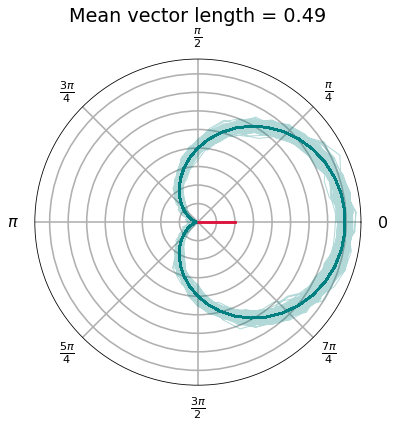

In [ ]:
with plt.style.context([{'pdf.fonttype':42}, 'seaborn-poster', {'lines.linewidth':2.2}]):

    f, ax =plt.subplots(1, 1, figsize=(6,6))
    clean_env = abs(1 + 0.99 * signal_slow)
    ax.remove()
    ax = f.add_subplot(111, projection='polar')
    plot_complex_circle(signal_slow, signal_fast, lw=1, alpha=0.3, ax=ax, color='teal')
    plot_complex_circle(signal_slow, clean_env * carrier_fast, ax=ax, lw=2., color='teal')
    ax.set_ylim([0, 2.2])
    f.savefig('./Manuscripts/IMPRS_Poster/meanvectorlength.pdf', dpi=100)

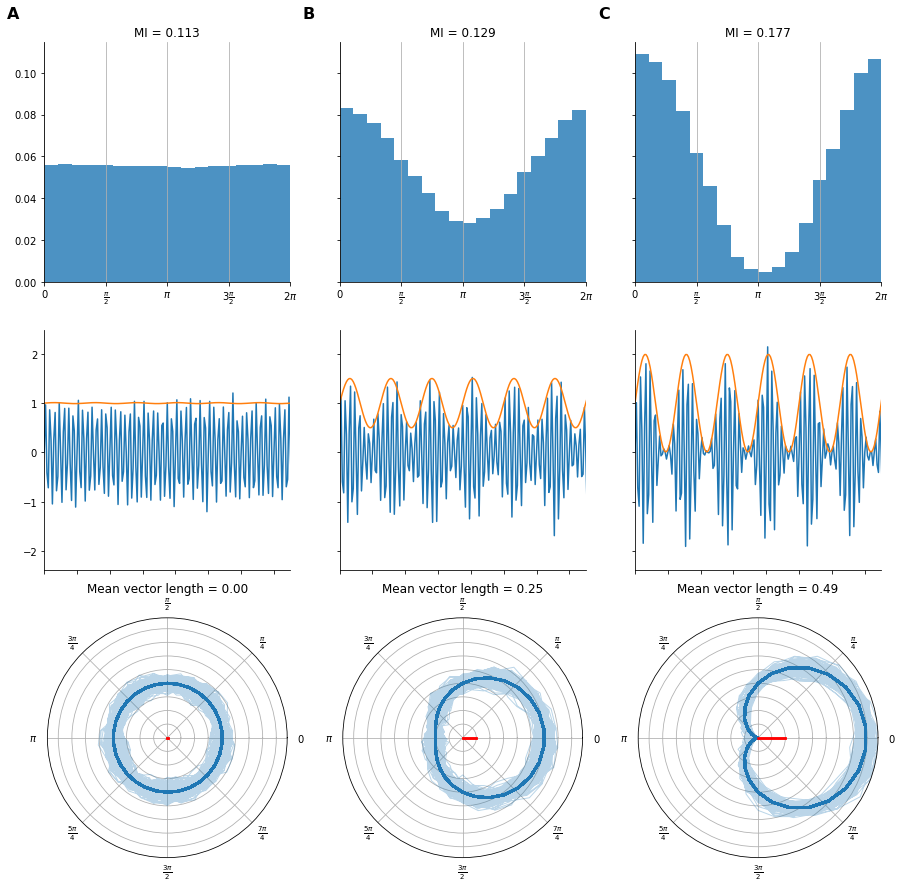

In [ ]:
mods = [0.01, 0.5, 0.99]
f, ax = plt.subplots(3, 3, figsize=(15, 15), sharey='row')
for k, m in enumerate(mods):
    # Some basic example
    signal_slow, signal_fast, env_fast, carrier_fast = generate_modulated_signal(t, m, noise=0.1)
    clean_env = abs(1 + m * signal_slow)
    signal_fast_onset, signal_fast_val = generate_event_modulated_signal(t, env_fast, carrier_fast)[:2]

    # Compute emprically phase of slow signal and amplitude (envelope) of fast one
    phase_slow = normalize_complex(hilbert(signal_slow))
    amp_fast = np.abs(hilbert(signal_fast))
    # Phase-amplitude distribution
    amp_pmf, phase_bins = compute_amp_phase_distribution(amp_fast, phase_slow)
    
    ###### Plots ##########
    # 1. Phase-Amplitude Distribution
    plot_phase_amp_distribution(phase_bins, amp_pmf, ax=ax[0, k])
    ax[0, k].set_title(f"MI = {modulation_index_tort2010(amp_pmf, phase_bins):.3f}")
    # 2. Signal and the modulating envelope
    #plot_sig(t, signal_fast, env_fast)
    plot_sig(t, signal_fast, clean_env, ax=ax[1, k])
    ax[1, k].set_xticklabels([])
    # 3. Circular plots (need to recreate axes)
    ax[2, k].remove()
    ax[2, k] = f.add_subplot(3, 3, 2*3+1+k, projection='polar')
    plot_complex_circle(signal_slow, signal_fast, lw=1, alpha=0.3, ax=ax[2, k])
    plot_complex_circle(signal_slow, clean_env * carrier_fast, ax=ax[2, k], lw=2.5, color='C0')
    ax[2,k].set_ylim([0, 2.2])
    
for i, label in enumerate(list('ABCDEFGH')[:len(mods)]):
    ax[0, i].text(-0.1, 1.15, label, transform=ax[0, i].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

Through panels **A** to **C** we observe an increase in modulation strength (0.01, 0.5 and 0.99 respectively). For each modulation coupling level I am showing (top panels) the phase-amplitude probability distribution, (middle panels) an excerpt of the resulting signal with slow modulator (envelope) overlaid, and (bottom panels) a polar plot of the analytical signal $A_{fast}(t)e^{i\theta_{slow}(t)}$ together with the Mean vector shown in red. Modulation index on the top panels' titles is measured from the KL divergence from a uniform distribution as prescribed in [Tort et al. (2010b)](https://journals.physiology.org/doi/full/10.1152/jn.00106.2010).

In [ ]:
import seaborn as sns

In [ ]:
signal_slow, signal_fast, env_fast, carrier_fast = generate_modulated_signal(t, 0.9, noise=0.1)
signal_fast_onset, signal_fast_val, onsets, valued, modulator_onset, modulator_value = generate_event_modulated_signal(t, env_fast, carrier_fast)

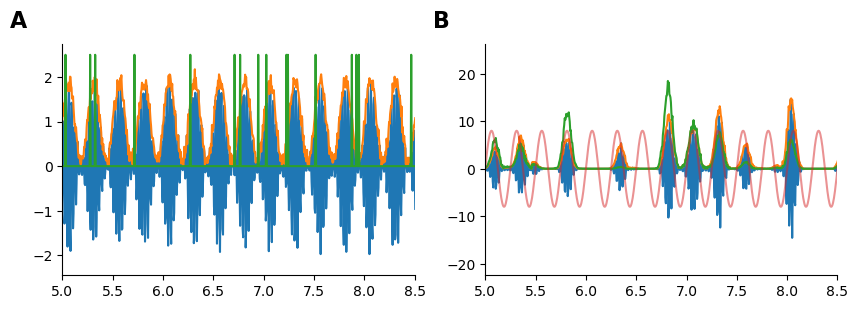

In [ ]:
signal_fast_onset, signal_fast_val, onsets, valued, modulator_onset, modulator_value = generate_event_modulated_signal(t, env_fast, carrier_fast)

f, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(t, signal_fast)
ax[0].plot(t, env_fast)
ax[0].plot(t, onsets*2.5)
ax[0].set_xlim([5, 8.5])

ax[1].plot(t, signal_fast_onset)
ax[1].plot(t, env_fast * modulator_onset)
ax[1].plot(t, env_fast * modulator_value)
ax[1].plot(t, signal_slow * 8, alpha=0.5)
ax[1].set_xlim([5, 8.5])

for i, label in enumerate(('A', 'B')):
    ax[i].text(-0.1, 1.15, label, transform=ax[i].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

sns.despine(f)

In [ ]:
signal_slow, signal_fast, env_fast, carrier_fast = generate_modulated_signal(t, 0.9, noise=0.1)
signal_fast_onset, signal_fast_val, onsets, valued, modulator_onset, modulator_value = generate_event_modulated_signal(t, env_fast, carrier_fast)

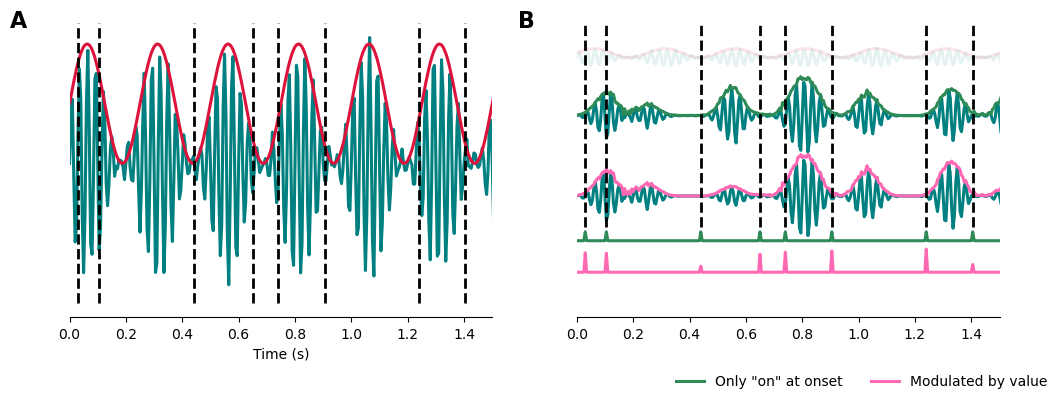

In [ ]:
with plt.style.context([{'pdf.fonttype':42}, {'lines.linewidth':2.2}]):
    
    f, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(t, signal_fast, color='teal') # modulated signal
    ax[0].plot(t, signal_slow+1, color='crimson') # modulator envelope
    ax[0].vlines(t[np.nonzero(onsets)], *ax[0].get_ylim(), color='k', zorder=2, ls='--', lw=2) # onsets (irrelevant here)
    ax[0].set_xlim([0, 1.5])

    ax[1].plot(t, 23 + signal_fast, color='teal', alpha=0.1) # modulated signal
    ax[1].plot(t, 23 + signal_slow +1, alpha=0.1, color='crimson') # former modulator
    ax[1].plot(t, 10 + signal_fast_onset, color='teal') # modulated signal
    ax[1].plot(t, 10 + env_fast * modulator_onset, color='seagreen') # modulator envelope via onset
    ax[1].plot(t, -8 + signal_fast_val, color='teal') # modulated signal
    ax[1].plot(t, -8 + env_fast * modulator_value, color='hotpink') # # modulator envelope via values
    ax[1].plot(t, -18 + onsets*2, 'seagreen', label='Only "on" at onset')
    ax[1].plot(t, -25 + (valued - valued.mean())*4, 'hotpink', label='Modulated by value')
    f.legend(frameon=False, ncol=2, loc='right', bbox_to_anchor=(0.85, -0.05, 0.1, -0.))
    ax[1].set_xlim([0., 1.5])
    #ax[1].set_ylim([-5, 10.])
    ax[1].vlines(t[np.nonzero(onsets)], -15, ax[1].get_ybound()[1], color='k', zorder=2, ls='--', lw=2)

    for i, label in enumerate(('A', 'B')):
        ax[i].text(-0.1, 1., label, transform=ax[i].transAxes,
          fontsize=16, fontweight='bold', va='top', ha='right')

    sns.despine(f)
    sns.despine(ax=ax[1], left=True)
    ax[1].set_yticklabels([])
    ax[1].set_yticks([])
    sns.despine(ax=ax[0], left=True)
    ax[0].set_yticklabels([])
    ax[0].set_yticks([])
    ax[0].set_xlabel("Time (s)")
    
    # f.savefig('./Manuscripts/IMPRS_Poster/example_simulation_PAC_2.pdf', dpi=100, bbox_inches='tight')

The panel **A** shows the amplitude modulated "fast" signal. We observe there that the modulation happens irrelative to timing of events. Unlike in **B** where the modulation is only (non-zero and) occurring after those events, but always in phase with the slow signal.

We can compute the global _modulation index_ for each of the afore mentioned metrics. "Global" here means that the MI value is estimated throughout the entire time-series, thus averaging across time (and no trials). In that way, there is absolutely no notion of event timing, and therefore we cannot get a time-resolved MI.

Signal of interest for computation of modulaiton index.

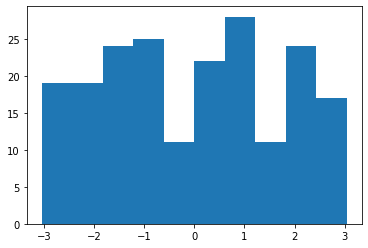

In [ ]:
phases_onset = np.angle(normalize_complex(hilbert(signal_slow)))[onsets!=0]

plt.hist(phases_onset);


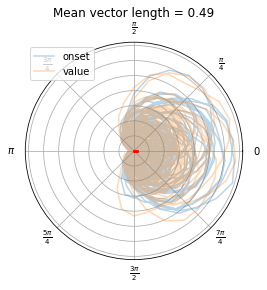

In [ ]:
plot_complex_circle(signal_slow, signal_fast_onset, alpha=0.3, label='onset');
plot_complex_circle(signal_slow, signal_fast_val, alpha=0.3, label='value', ax=plt.gca());
plt.legend()

<BarContainer object of 18 artists>

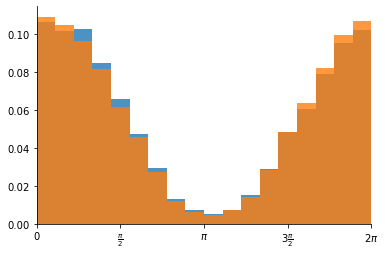

In [ ]:
amp_pmf, phase_bins = compute_amp_phase_distribution(abs(hilbert(signal_fast_val)), normalize_complex(hilbert(signal_slow))) 
plot_phase_amp_distribution(phase_bins, amp_pmf)
amp_pmf, phase_bins = compute_amp_phase_distribution(abs(hilbert(signal_fast)), normalize_complex(hilbert(signal_slow))) 
plot_phase_amp_distribution(phase_bins, amp_pmf, ax=plt.gca())

In [ ]:
signal_slow, signal_fast, env_fast, carrier_fast = generate_modulated_signal(t, 0.99, noise=0.06)
signal_fast_onset, signal_fast_val, onsets, valued, modulator_onset, modulator_value = generate_event_modulated_signal(t, env_fast, carrier_fast)

In [ ]:
phase_slow = normalize_complex(hilbert(signal_slow))
amp_fast = np.abs(hilbert(signal_fast))

Global modulation index (across entire time-series):
----------------------------------------------------
Mean vector: 		0.486
Mean vector bis: 	0.397
PLV: 			0.566
KL: 			0.093



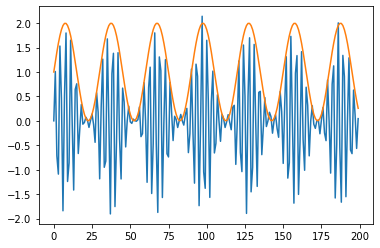

In [ ]:
plt.plot(signal_fast[:200])
plt.plot(1+signal_slow[:200])

mi = compute_all_MI(amp_fast, np.angle(phase_slow))
print(f"""Global modulation index (across entire time-series):
----------------------------------------------------
Mean vector: \t\t{mi.mean_vector:.3f}
Mean vector bis: \t{mi.normalised_mean_vector:.3f}
PLV: \t\t\t{mi.plv:.3f}
KL: \t\t\t{mi.kl:.3f}
""")

For a parametrised compound signal (multiplexed), we can do the following, and then filter each band of interest respectively.

Global modulation index (across entire time-series):
----------------------------------------------------
Mean vector: 		0.120
Mean vector bis: 	0.196
PLV: 			0.221
KL: 			0.016



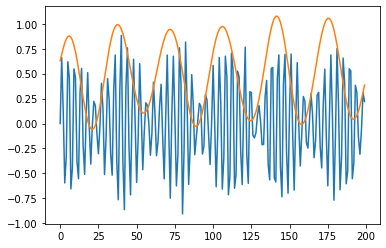

In [ ]:
from scipy.signal import fir_filter_design, freqz

ki = 0.5
Amp_s = .5
Amp = (1+ki+(1-ki)*np.sin(2*np.pi*f_slow*t))
x_raw = Amp * np.sin(2*np.pi * f_fast *t) + Amp_s * np.sin(2*np.pi*f_slow*t + np.random.rand()) + 0.2*np.random.randn(*t.shape)

b1 = fir_filter_design.firwin2(81, [0, 1, 5, 8, fs/2], [0, 1, 1,0, 0], fs=fs)
b2 = fir_filter_design.firwin2(81, [0, 25,30,40, fs/2], [0, 0,1,1, 0], fs=fs)
sig_slow = filtfilt(b1, 1, x_raw)
sig_fast = filtfilt(b2, 1, x_raw)
plt.plot(sig_fast[:200])
plt.plot(Amp_s+sig_slow[:200])

mi = compute_all_MI(hilbert(sig_fast), hilbert(sig_slow))
print(f"""Global modulation index (across entire time-series):
----------------------------------------------------
Mean vector: \t\t{mi.mean_vector:.3f}
Mean vector bis: \t{mi.normalised_mean_vector:.3f}
PLV: \t\t\t{mi.plv:.3f}
KL: \t\t\t{mi.kl:.3f}
""")

In [ ]:
lags = np.arange(-0.2, 0.6 + 1/fs, 1/fs)
trf = TRFEstimator(tmin=lags[0], tmax=lags[-1], srate=fs, alpha=1e-2)
kernel = norm.pdf(lags, loc=0.1, scale=0.05)
kernel /= np.std(kernel)
#lags = lags[:-1]

In [ ]:
lags = trf.times

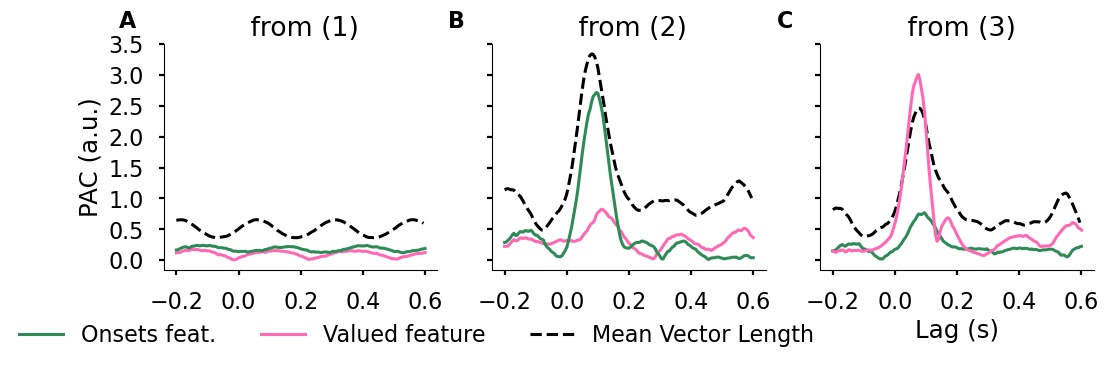

In [ ]:
with plt.style.context([{'pdf.fonttype':42}, {'lines.linewidth':2.2}]):

    f, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True, dpi=100)
    amp_fast = abs(hilbert(signal_fast))
    trf.fit(np.c_[onsets, valued], np.expand_dims(amp_fast * phase_slow, -1))
    ax[0].plot(lags, abs(trf.coef_.squeeze())[:, 1], label='valued', color='hotpink')
    ax[0].plot(lags, abs(trf.coef_.squeeze())[:, 0], label='onset', color='seagreen')
    ax[0].set_title(f" from (1)")
    # Epoch based PAC
    epochs = []
    for ons in np.nonzero(onsets)[0]:
        if t[ons] -0.2 > t[0] and t[ons] + 0.6 < t[-1]:
            tstart = np.argmin(abs(t - (t[ons]-0.2)))
            tend = np.argmin(abs(t - (t[ons]+0.6)))
            epochs.append((amp_fast * phase_slow)[tstart:tend])
    ax[0].plot(lags[:-1], np.abs(np.stack(epochs).mean(0)), color='k', ls='--', );
    ax[0].set_ylabel('PAC (a.u.)')
    
    amp_fast = abs(hilbert(signal_fast_onset))
    trf.fit(np.c_[onsets, valued], np.expand_dims(amp_fast * phase_slow, -1))
    ax[1].plot(lags, abs(trf.coef_.squeeze())[:, 1], label='valued', color='hotpink')
    ax[1].plot(lags, abs(trf.coef_.squeeze())[:, 0], label='onset', color='seagreen')
    ax[1].set_title(f" from (2)")
    # Epoch based PAC
    epochs = []
    for ons in np.nonzero(onsets)[0]:
        if t[ons] -0.2 > t[0] and t[ons] + 0.6 < t[-1]:
            tstart = np.argmin(abs(t - (t[ons]-0.2)))
            tend = np.argmin(abs(t - (t[ons]+0.6)))
            epochs.append((amp_fast * phase_slow)[tstart:tend])
    ax[1].plot(lags[:-1], np.abs(np.stack(epochs).mean(0)), color='k', ls='--', zorder=0);
    
    amp_fast = abs(hilbert(signal_fast_val))
    trf.fit(np.c_[onsets, valued], np.expand_dims(amp_fast * phase_slow, -1))
    ax[2].plot(lags, abs(trf.coef_.squeeze())[:, 0], label='Onsets feat.', color='seagreen')
    ax[2].plot(lags, abs(trf.coef_.squeeze())[:, 1], label='Valued feature', color='hotpink')
    # Epoch based PAC
    epochs = []
    for ons in np.nonzero(onsets)[0]:
        if t[ons] -0.2 > t[0] and t[ons] + 0.6 < t[-1]:
            tstart = np.argmin(abs(t - (t[ons]-0.2)))
            tend = np.argmin(abs(t - (t[ons]+0.6)))
            epochs.append((amp_fast * phase_slow)[tstart:tend])
    ax[2].plot(lags[:-1],  np.abs(np.stack(epochs).mean(0)), color='k', ls='--', label='Mean Vector Length', zorder=0);
    ax[2].set_title(" from (3)")
    ax[2].legend(frameon=False, loc='best', bbox_to_anchor=(-0.05, -0.15, 0.1, 0.), ncol=3);
    # Some labels
    for i, label in enumerate(('A', 'B', 'C')):
        ax[i].text(-0.1, 1.15, label, transform=ax[i].transAxes,
          fontsize=16, fontweight='bold', va='top', ha='right')
    ax[2].set_xlabel('Lag (s)')
        
    sns.despine()
    # f.savefig('./Manuscripts/IMPRS_Poster/simu.pdf', dpi=100, bbox_inches='tight')

## Paper format

In [ ]:
from matplotlib import font_manager
font_dirs = ["/home/lacnsg/hugwei/Helvetica-Font/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

paper_fonts = {
     'axes.labelsize': 7,
     'axes.titlesize': 7,
     'xtick.labelsize': 6,
     'ytick.labelsize': 6,
     'legend.fontsize': 7,
}

other_options = {
    'figure.figsize' : [7.2, 5.4],
    'figure.dpi' : 100,
    'font.family' : 'sans',
    'font.sans-serif' : 'Helvetica',
    'font.size' : 7,
    'pdf.fonttype' : 42,
    'savefig.transparent' : True,
    'savefig.bbox' : 'tight',
    'savefig.dpi' : 300,
    'xtick.major.width' : 0.6,
    'ytick.major.width' : 0.6,
    'axes.linewidth' : 0.7,
}

plot_options = paper_fonts | other_options

In [ ]:
signal_slow, signal_fast, env_fast, carrier_fast = generate_modulated_signal(t, 0.9, noise=0.1)
signal_fast_onset, signal_fast_val, onsets, valued, modulator_onset, modulator_value = generate_event_modulated_signal(t, env_fast, carrier_fast)

INFO:pyeeg:Lagging matrix...
INFO:pyeeg:Computing coefficients..
INFO:pyeeg:Lagging matrix...
INFO:pyeeg:Computing coefficients..
INFO:pyeeg:Lagging matrix...
INFO:pyeeg:Computing coefficients..


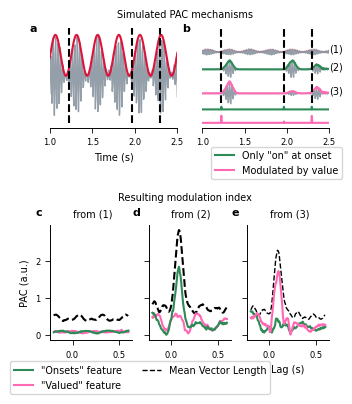

In [ ]:
with plt.style.context([plot_options]):
    figure = plt.figure(figsize=(7.2/2, 1.5+2))
    figs = figure.subfigures(2, 1, height_ratios=[1.5, 1.65], hspace=0.45)
    
    # ------ subfig 1 ----------
    ax = figs[0].subplots(1, 2)

    ax[0].plot(t, signal_fast, color='#959fa9', lw=1) # modulated signal
    ax[0].plot(t, signal_slow+1, color='crimson') # modulator envelope
    ax[0].vlines(t[np.nonzero(onsets)], *ax[0].get_ylim(), color='k', zorder=2, ls='--', ) # onsets (irrelevant here)
    ax[0].set_xlim([1, 2.5])

    ax[1].plot(t, 23 + signal_fast, color='#959fa9') # modulated signal
    ax[1].plot(t, 23 + signal_slow +1, alpha=0.1, color='crimson') # former modulator
    ax[1].annotate('(1)', (2.5, 23))
    ax[1].plot(t, 10 + signal_fast_onset, color='#959fa9', lw=1) # modulated signal
    ax[1].plot(t, 10 + env_fast * modulator_onset, color='seagreen') # modulator envelope via onset
    ax[1].annotate('(2)', (2.5, 10))
    ax[1].plot(t, -8 + signal_fast_val, color='#959fa9', lw=1) # modulated signal
    ax[1].plot(t, -8 + env_fast * modulator_value, color='hotpink') # # modulator envelope via values
    ax[1].annotate('(3)', (2.5, -8))

    # Pulses
    ax[1].plot(t, -20 + onsets*2, 'seagreen', label='Only "on" at onset')
    ax[1].plot(t, -30 + (valued - valued.mean())*4, 'hotpink', label='Modulated by value')
    figs[0].legend(frameon=True, ncol=1, loc='right', bbox_to_anchor=(0.85, -0.15, 0.1, -0.))
    ax[1].set_xlim([1., 2.5])
    #ax[1].set_ylim([-5, 10.])
    ax[1].vlines(t[np.nonzero(onsets)], -15, ax[1].get_ybound()[1], color='k', zorder=2, ls='--',)

    for i, label in enumerate(('a', 'b')):
        ax[i].text(-0.1, 1., label, transform=ax[i].transAxes,
          fontsize=8, fontweight='bold', va='top', ha='right')

    sns.despine(figs[0])
    sns.despine(ax=ax[1], left=True)
    ax[1].set_yticklabels([])
    ax[1].set_yticks([])
    sns.despine(ax=ax[0], left=True)
    ax[0].set_yticklabels([])
    ax[0].set_yticks([])
    ax[0].set_xlabel("Time (s)")
    figs[0].suptitle('Simulated PAC mechanisms', fontsize=7)

    # ---- subfig 2 ----------------
    ax = figs[1].subplots(1, 3, sharey=True)
    lags = np.arange(-0.2, 0.6 + 1/fs, 1/fs)
    trf = TRFEstimator(tmin=lags[0], tmax=lags[-1], srate=fs, alpha=1e-2)
    amp_fast = abs(hilbert(signal_fast))
    trf.fit(np.c_[onsets, valued], np.expand_dims(amp_fast * phase_slow, -1))
    ax[0].plot(lags, abs(trf.coef_.squeeze())[:, 1], color='hotpink')
    ax[0].plot(lags, abs(trf.coef_.squeeze())[:, 0], color='seagreen')
    ax[0].set_title(f" from (1)")
    # Epoch based PAC
    epochs = []
    for ons in np.nonzero(onsets)[0]:
        if t[ons] -0.2 > t[0] and t[ons] + 0.6 < t[-1]:
            tstart = np.argmin(abs(t - (t[ons]-0.2)))
            tend = np.argmin(abs(t - (t[ons]+0.6)))
            epochs.append((amp_fast * phase_slow)[tstart:tend])
    ax[0].plot(lags[:-1], np.abs(np.stack(epochs).mean(0)), color='k', ls='--', );
    ax[0].set_ylabel('PAC (a.u.)')
    
    amp_fast = abs(hilbert(signal_fast_onset))
    trf.fit(np.c_[onsets, valued], np.expand_dims(amp_fast * phase_slow, -1))
    ax[1].plot(lags, abs(trf.coef_.squeeze())[:, 1], color='hotpink')
    ax[1].plot(lags, abs(trf.coef_.squeeze())[:, 0], color='seagreen')
    ax[1].set_title(f" from (2)")
    # Epoch based PAC
    epochs = []
    for ons in np.nonzero(onsets)[0]:
        if t[ons] -0.2 > t[0] and t[ons] + 0.6 < t[-1]:
            tstart = np.argmin(abs(t - (t[ons]-0.2)))
            tend = np.argmin(abs(t - (t[ons]+0.6)))
            epochs.append((amp_fast * phase_slow)[tstart:tend])
    ax[1].plot(lags[:-1], np.abs(np.stack(epochs).mean(0)), color='k', ls='--', zorder=0);
    
    amp_fast = abs(hilbert(signal_fast_val))
    trf.fit(np.c_[onsets, valued], np.expand_dims(amp_fast * phase_slow, -1))
    ax[2].plot(lags, abs(trf.coef_.squeeze())[:, 0], label='"Onsets" feature', color='seagreen')
    ax[2].plot(lags, abs(trf.coef_.squeeze())[:, 1], label='"Valued" feature', color='hotpink')
    # Epoch based PAC
    epochs = []
    for ons in np.nonzero(onsets)[0]:
        if t[ons] -0.2 > t[0] and t[ons] + 0.6 < t[-1]:
            tstart = np.argmin(abs(t - (t[ons]-0.2)))
            tend = np.argmin(abs(t - (t[ons]+0.6)))
            epochs.append((amp_fast * phase_slow)[tstart:tend])
    ax[2].plot(lags[:-1],  np.abs(np.stack(epochs).mean(0)), color='k', ls='--', lw=1., label='Mean Vector Length', zorder=0);
    ax[2].set_title(" from (3)")
    figs[1].legend(frameon=True, bbox_to_anchor=(0.0, 0., 0.5, 0.), ncol=2, loc='upper left');
    # Some labels
    for i, label in enumerate(('c', 'd', 'e')):
        ax[i].text(-0.1, 1.15, label, transform=ax[i].transAxes,
          fontsize=8, fontweight='bold', va='top', ha='right')
    ax[2].set_xlabel('Lag (s)')
    figs[1].suptitle('Resulting modulation index', fontsize=7, y=1.1)
        
    sns.despine(figs[1])
    
    figure.savefig('./Manuscripts/SyntaxPaper/Figures/NewGen/example_simulation_PAC.pdf', dpi=300, bbox_inches='tight')